In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
key = ''# key from Tiingo website

In [0]:
df = pdr.get_data_tiingo('AAPL', api_key = key)

In [0]:
df.to_csv('AAPL.csv')

In [0]:
df = pd.read_csv('AAPL.csv')

In [9]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
1,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
2,AAPL,2015-06-03 00:00:00+00:00,130.120,130.940,129.90,130.66,30983542,119.908625,120.664274,119.705890,120.406248,30983542,0.0,1.0
3,AAPL,2015-06-04 00:00:00+00:00,129.360,130.580,128.91,129.58,38450118,119.208267,120.332526,118.793582,119.411002,38450118,0.0,1.0
4,AAPL,2015-06-05 00:00:00+00:00,128.650,129.690,128.36,129.50,35626800,118.553986,119.512370,118.286744,119.337280,35626800,0.0,1.0


In [0]:
df1 = df.reset_index()['close']

In [16]:
df1[1228:].head(5)

1228    286.69
1229    282.80
1230    276.93
1231    268.37
1232    276.10
Name: close, dtype: float64

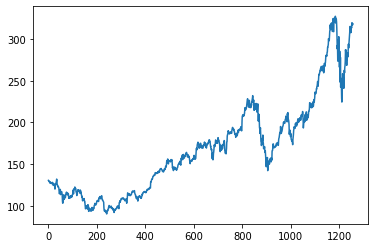

In [17]:
plt.plot(df1)

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))

In [0]:
df1= scaler.fit_transform(np.array(df1).reshape(-1,1))

In [23]:
df1.shape

(1257, 1)

In [24]:
df1

array([[0.1696994 ],
       [0.16727181],
       [0.16794731],
       ...,
       [0.96491598],
       [0.95579667],
       [0.9616229 ]])

In [0]:
# spliting data into training and test data
training_size= int(len(df1)*0.65)
test_size= len(df1)-training_size
train_data, test_data= df1[0:training_size,:],df1[training_size:len(df1),:1]

In [29]:
training_size,test_size

(817, 440)

In [33]:
train_data[:5]

array([[0.1696994 ],
       [0.16727181],
       [0.16794731],
       [0.16473866],
       [0.16174111]])

In [0]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [0]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [40]:
X_train.shape, y_train.shape

((716, 100), (716,))

In [42]:
X_test.shape, y_test.shape

((339, 100), (339,))

In [0]:
#reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [0]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [0]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 191ms/step - loss: 0.0022 - val_loss: 0.0135
Epoch 2/100
12/12 [==============================] - 2s 193ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 3/100
12/12 [==============================] - 2s 193ms/step - loss: 7.2345e-04 - val_loss: 0.0039
Epoch 4/100
12/12 [==============================] - 2s 189ms/step - loss: 6.9449e-04 - val_loss: 0.0048
Epoch 5/100
12/12 [==============================] - 2s 190ms/step - loss: 6.3393e-04 - val_loss: 0.0048
Epoch 6/100
12/12 [==============================] - 2s 189ms/step - loss: 6.2402e-04 - val_loss: 0.0038
Epoch 7/100
12/12 [==============================] - 2s 189ms/step - loss: 5.8867e-04 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 2s 192ms/step - loss: 6.2321e-04 - val_loss: 0.0035
Epoch 9/100
12/12 [==============================] - 2s 194ms/step - loss: 5.7052e-04 - val_loss: 0.0037
Epoch 10/100
12/12 [==============================] - 2s 195ms/

In [51]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [0]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [54]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

142.6264724465841

In [55]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

238.88038201099408

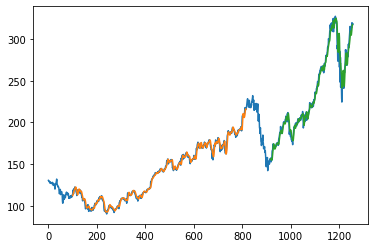

In [56]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [57]:
len(test_data)

440

In [58]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 99)

In [63]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
len(temp_input)

99

In [61]:
temp_input[:10]

[0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076]

In [66]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=99
i=0
while(i<30):
    
    if(len(temp_input)>99):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output[:10])

[0.95354444]
100
1 day input [0.87836697 0.8986321  0.92582116 0.92877649 0.95676771 0.93869797
 0.93304061 0.94950604 0.96424048 0.95512117 0.95989192 0.96635143
 0.96246728 0.92295027 0.9598497  0.98792536 0.98594106 0.92531453
 0.92172591 0.96474711 0.97572406 0.99159841 0.96972895 0.97614625
 0.96795575 1.         0.99016297 0.99050072 0.96538039 0.98488559
 0.97086887 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823
 0.77269273 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995
 0.74233725 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044
 0.68614371 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673
 0.65515494 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197
 0.65266402 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111
 0.77222832 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492
 0.75162543 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106
 0.83336148 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403
 0.90095415 0.92793211 0.948535  

In [0]:
day_new=np.arange(1,100)
day_pred=np.arange(100,130)

In [78]:
len(day_new),len(df1[1158:])

(99, 99)

In [74]:
len(day_pred) ,len(lst_output)

(30, 30)

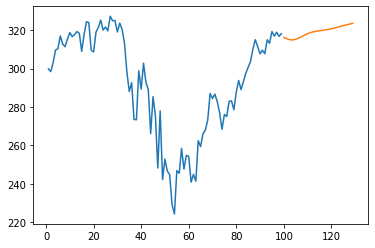

In [79]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

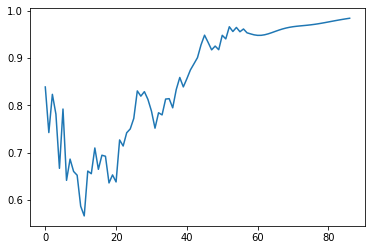

In [80]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [0]:
df3=scaler.inverse_transform(df3).tolist()

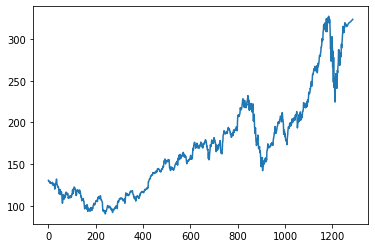

In [82]:
plt.plot(df3)